In [3]:
%reset -f
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os, sys
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import polytope as pc
from control.matlab import *

sys.path.append(os.path.join(os.getcwd(), 'my_lib'))

from func_plot import *
from func_polytope import *
from func_mpc import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
def system_model():

    # 連続システム定義
    Ac = np.array([[0,1,0],[0,-5.7e-4, 2.07],[0,0,-1.25]])
    Bc = np.array([[0],[0],[-1.25]])
    Bf = np.array([[0],[1],[0]])
    Cc = np.array([[1, 0, 0]])
    Dc = 0

    # 離散システム
    dt= 0.2;
    sysc = ss(Ac, Bc, Cc, Dc)
    sysd = c2d(sysc, dt, method='tustin')
    
    # 状態集合
    B = pc.box2poly([[-200, 3],[-3, 30],[-1, 1]])
    S = polytope_h(np.array([[-1, 0, 0],
                             [-0.03, -1.0, 0],
                             [0.2, 1.0, 0],
                             [0,0,1],
                             [0,0,-1]]), 
                   np.array([[200],[0],[0],[1],[1]]))
    T = pc.box2poly([[-0.3, 0.3],[-0.1, 1],[-1, 1]])
    X = intersect(B, plus(S,T))

    # 演算
    sys = system()
    sys.A  = sysd.A
    sys.Bu = sysd.B
    sys.X  = X
    sys.U  = polytope_h(np.array([[1],[-1]]), np.array([[1],[1]]))
    sys.E  = polytope_h(np.array([[1],[-1]]), np.array([[1/31],[1/31]]))

    return sys

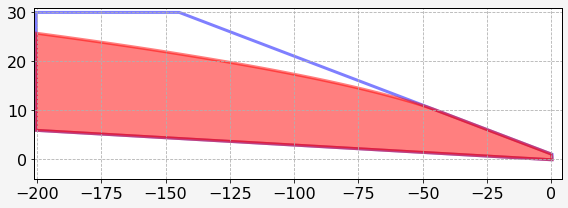

In [82]:
compute = False

fig, ax = Fig(size=(8,3),col=1)

if compute:
    sys = system_model()
    sys.Xf = InvariantSet(sys, fig=ax[0])
else:
    sys = load_system()

Xp = project(sys.X,[0,1])
Xf_p = project(sys.Xf, [0,1])

Xp.plot(ax[0], alpha=0.5, color='None', edgecolor='b', linestyle='-')
Xf_p.plot(ax[0], alpha=0.5, color='r', edgecolor='r', linestyle='-');
ax[0].set_xlim([-201,4])
ax[0].set_ylim([-4,31]);


In [157]:
nx = sys.A.shape[1]
nu = sys.Bu.shape[1]
A1 = np.hstack([sys.A, sys.Bu])
A2 = np.hstack([np.zeros([nu,nx]), np.eye(nu)])
A = np.vstack([A1,A2])
Bu = np.vstack([sys.Bu, np.eye(nu)])
nx = A.shape[1]
nu = Bu.shape[1]

Q  = np.diag([1e-3/200, 1e-3/30, 1e-1/1, 1e-3/1])
R  = 1e2*np.ones([1,1])
S  = 1e3*np.ones([1,1])

P  = cp.Variable((nx, nx), symmetric=True)
K  = cp.Variable((nu, nx))

M  = cp.bmat([[P,          (A@P+Bu@K).T,      P,                 K.T],
              [(A@P+Bu@K), P,                 np.zeros([nx,nx]), np.zeros([nx,nu])],
              [P,          np.zeros([nx,nx]), np.linalg.inv(Q),  np.zeros([nx,nu])],
              [K,          np.zeros([nu,nx]), np.zeros([nu,nx]), np.linalg.inv(R)]])
constr = [P >> 0]
constr += [M >> 0]

target = cp.Maximize(cp.trace(P))
prob   = cp.Problem(target, constr)
result = prob.solve(solver="CVXOPT", verbose=False)

w,v=np.linalg.eig(P.value)
print(w)

P = np.array(P.value)
P = np.linalg.inv(P)
K = K.value @ P
print('K=',K)
print('P=',P)


[6182.74323   40.61245    3.61079    0.16202]
K= [[ 0.00022  0.0038   0.00748 -0.06048]]
P= [[ 0.00044  0.00374  0.0055  -0.02167]
 [ 0.00374  0.0523   0.07863 -0.37997]
 [ 0.0055   0.07863  0.37089 -0.7499 ]
 [-0.02167 -0.37997 -0.7499   6.0502 ]]


In [165]:
N = 2
x = cp.Variable([nx,N+1])
u = cp.Variable([nu,N])
z = cp.Variable([1,N])
HC,KC = sys.Xf.A, sys.Xf.b
HU,KU = sys.U.A, sys.U.b
KU = np.array(KU).reshape(len(KU),1)

cost = cp.quad_form(x[:,N],P)
cost2 = cost
constr = []
for k in range(N):
    # running stage-cost
    cost += cp.quad_form(x[:,k],Q) + cp.quad_form(u[:,k],R) + cp.quad_form(z[:,k],S)
    cost2 += cp.quad_form(x[:,k],Q) + R*cp.norm(u[:,k],2) + cp.quad_form(z[:,k],S)
    
    # dynamic equality constraint
    constr += [x[:,k+1] == A@x[:,k] + Bu@u[:,k]]
    
    # state and input constraint
    constr += [HC@x[0:3,k+1]<=KC*z[0,k]]
    constr += [HU*x[3,k+1]<=KU]
    constr += [0 <= z[0,k]]
    constr += [z[0,k] <= 0.99]
    

In [166]:
def sim(x0, cost, constr, A, Bu):
    x_buff = x0
    t_buff = 0
    t_f = 35*5
    for i in range(t_f):
        constr_ = constr + [x[:,0] == x0[:,0]]
        prob = cp.Problem(cp.Minimize(cost), constr_)

        result = prob.solve(solver="CVXOPT",verbose=False)
        u_in = u.value[0][0]
        u_in = round(u_in*31.0)/31.0

        x0 = A @ x0 + Bu * u_in   
        x0 = np.asarray(x0)

        x_buff = np.hstack([x_buff,x0])
        t_buff = np.hstack([t_buff,i*0.2])

        print("\r{:3}%".format(round(i/t_f*100)), end="")
    return t_buff, x_buff

In [167]:
# test1
x0 = np.array([[-200],[20],[0],[0]])
t_buff1, x_buff1 = sim(x0, cost, constr, A, Bu)

# test2
t_buff2, x_buff2 = sim(x0, cost2, constr, A, Bu)

 99%

False

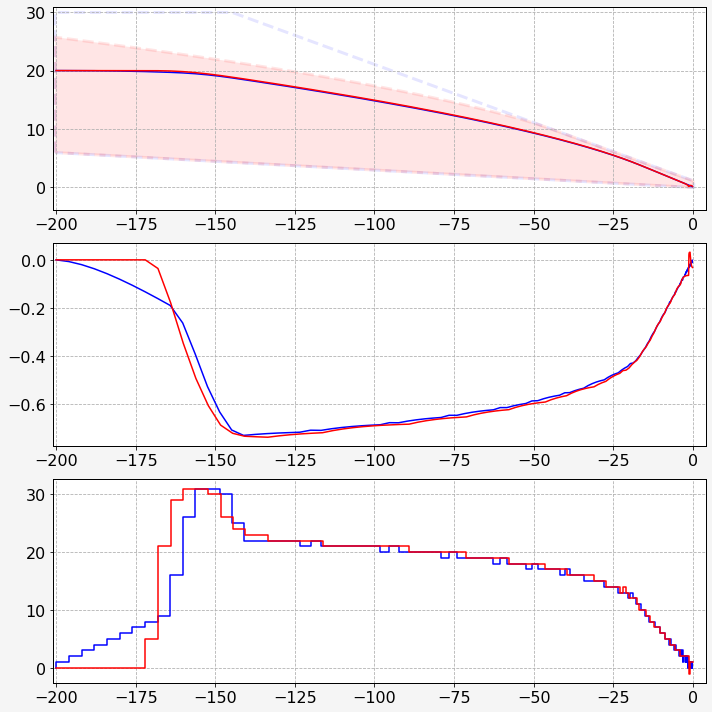

In [168]:
fig, ax = Fig(size=(10,10),row=3)
xlim(ax,[-201,4])
ax[0].set_ylim([-4,31]);

#xlim(ax,[-1,1])
#ax[0].set_ylim([-0.5,0.5]);


Xp.plot(ax[0], alpha=0.1, color='None', edgecolor='b', linestyle='--')
Xf_p.plot(ax[0], alpha=0.1, color='r', edgecolor='r', linestyle='--');

ax[0].plot(x_buff1[0], x_buff1[1], color="b", linestyle="-")
ax[1].plot(x_buff1[0], x_buff1[2], color="b")
ax[2].step(x_buff1[0], x_buff1[3]*31, color="b", linestyle="-")

ax[0].plot(x_buff2[0], x_buff2[1], color="r", linestyle="-")
ax[1].plot(x_buff2[0], x_buff2[2], color="r")
ax[2].step(x_buff2[0], x_buff2[3]*31, color="r")
[-175, 25] in Xf_p